# Modeling and Simulation in Python

Chapter 8

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Functions from the previous chapter

In [2]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [3]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Reading the data

In [6]:
table2 = pd.read_csv('../World_population_estimates2.csv')
table2.index = table2.Year
table2.head()

,Year,census,prb,un,maddison,hyde,tanton,biraben,mj,thomlinson,durand,clark
Year,,,,,,,,,,,,
1950,1950,2557628654,2.516000e+09,2.525149e+09,2.544000e+09,2.527960e+09,2.400000e+09,2.527000e+09,2.500000e+09,2.400000e+09,NaN,2.486000e+09
1951,1951,2594939877,NaN,2.572851e+09,2.571663e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1952,1952,2636772306,NaN,2.619292e+09,2.617949e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953,1953,2682053389,NaN,2.665865e+09,2.665959e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1954,1954,2730228104,NaN,2.713172e+09,2.716927e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN


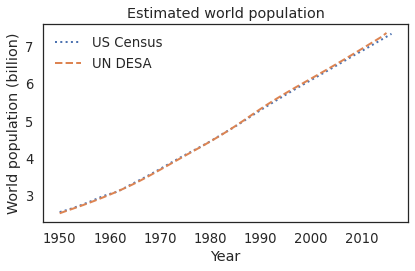

In [7]:
un = table2.un / 1e9
census = table2.census / 1e9
plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title='Estimated world population')

### Running the quadratic model

Here's the update function for the quadratic growth model with parameters `alpha` and `beta`.

In [8]:
def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

Extract the starting time and population.

In [9]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = get_first_value(census)

2.557628654

Initialize the system object.

In [10]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


Run the model and plot results.

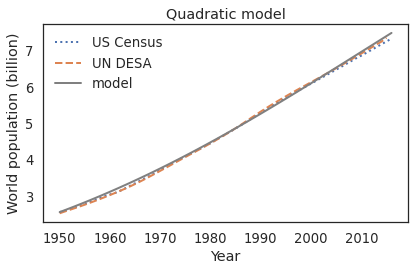

In [11]:
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Generating projections

To generate projections, all we have to do is change `t_end`

Saving figure to file chap08-fig01.pdf


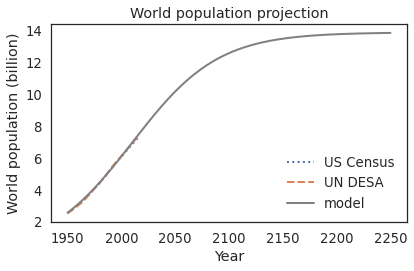

In [12]:
system.t_end = 2250
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')
savefig('chap08-fig01.pdf')

The population in the model converges on the equilibrium population, `-alpha/beta`

In [13]:
results[system.t_end]

13.856665141368708

In [14]:
-system.alpha / system.beta

13.88888888888889

**Exercise:**  What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

/tmp/ipykernel_10643/2575433194.py:8: RuntimeWarning: overflow encountered in double_scalars
  net_growth = system.alpha * pop + system.beta * pop**2


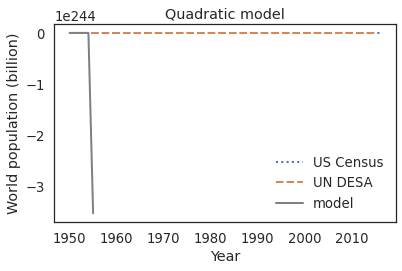

In [15]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=20000000000,
                alpha=0.025,
                beta=-0.0018)

results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

Everybody dies immediately?

### Comparing projections

We can compare the projection from our model with projections produced by people who know what they are doing.

In [39]:
table3 = pd.read_csv('../World_population_estimates3.csv')
table3.index = table3.Year
table3.head()
table3.tail()

,Year,census,prb,un
Year,,,,
2080,2080,NaN,NaN,1.083664e+10
2085,2085,NaN,NaN,1.095352e+10
2090,2090,NaN,NaN,1.105527e+10
2095,2095,NaN,NaN,1.114246e+10
2100,2100,NaN,NaN,1.121332e+10


`NaN` is a special value that represents missing data, in this case because some agencies did not publish projections for some years.

This function plots projections from the UN DESA and U.S. Census.  It uses `dropna` to remove the `NaN` values from each series before plotting it.

In [17]:
def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census / 1e9
    un_proj = table.un / 1e9
    
    plot(census_proj.dropna(), ':', color='C0', label='US Census')
    plot(un_proj.dropna(), '--', color='C1', label='UN DESA')

Run the model until 2100, which is as far as the other projections go.

In [18]:
system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

,values
t_0,1950.000000
t_end,2100.000000
p_0,2.557629
alpha,0.025000
beta,-0.001800


Saving figure to file chap08-fig02.pdf


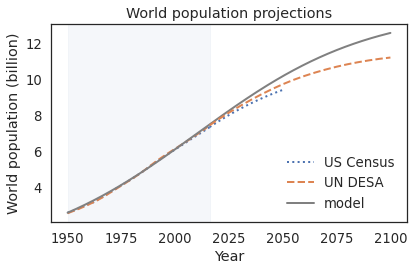

In [19]:
results = run_simulation(system, update_func_quad)

plt.axvspan(1950, 2016, color='C0', alpha=0.05)
plot_results(census, un, results, 'World population projections')
plot_projections(table3)
savefig('chap08-fig02.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

## Exercises

**Exercise:** The net growth rate of world population has been declining for several decades.  That observation suggests one more way to generate projections, by extrapolating observed changes in growth rate.

The `modsim` library provides a function, `compute_rel_diff`, that computes relative differences of the elements in a sequence.

Here's how we can use it to compute the relative differences in the `census` and `un` estimates:

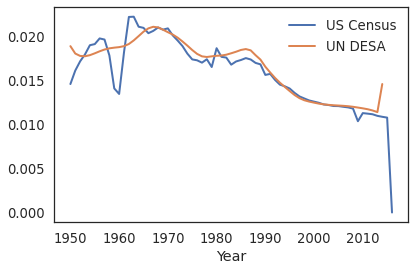

In [20]:
alpha_census = compute_rel_diff(census)
plot(alpha_census, label='US Census')

alpha_un = compute_rel_diff(un)
plot(alpha_un, label='UN DESA')

decorate(xlabel='Year', label='Net growth rate')

Other than a bump around 1990, net growth rate has been declining roughly linearly since 1965.  As an exercise, you can use this data to make a projection of world population until 2100.

1. Define a function, `alpha_func`, that takes `t` as a parameter and returns an estimate of the net growth rate at time `t`, based on a linear function `alpha = intercept + slope * t`.  Choose values of `slope` and `intercept` to fit the observed net growth rates since 1965.

2. Call your function with a range of `ts` from 1960 to 2020 and plot the results.

3. Create a `System` object that includes `alpha_func` as a system variable.

4. Define an update function that uses `alpha_func` to compute the net growth rate at the given time `t`.

5. Test your update function with `t_0 = 1960` and `p_0 = census[t_0]`.

6. Run a simulation from 1960 to 2100 with your update function, and plot the results.

7. Compare your projections with those from the US Census and UN.

In [51]:
def alpha_func(t):
    """Compute the net growth rate.
    
    t: what year it is
    returns: growth rate for time t
    """
    b = system.alpha
    m = system.beta
    return m * t + b

def alpha_growth(pop, t, syst = None):
    return pop * (alpha_func(t) +1)

In [54]:
system = System(t_0 = 1960, 
                t_end = 2100,
                p_0 = p_0,
                alpha = 0.025,
                beta = -0.0018,
                alpha_func = alpha_func)

period = linspace(1960, 2010, 50)
alphas = system.alpha_func(period)

array([-3.503     , -3.50483673, -3.50667347, -3.5085102 , -3.51034694,
       -3.51218367, -3.51402041, -3.51585714, -3.51769388, -3.51953061,
       -3.52136735, -3.52320408, -3.52504082, -3.52687755, -3.52871429,
       -3.53055102, -3.53238776, -3.53422449, -3.53606122, -3.53789796,
       -3.53973469, -3.54157143, -3.54340816, -3.5452449 , -3.54708163,
       -3.54891837, -3.5507551 , -3.55259184, -3.55442857, -3.55626531,
       -3.55810204, -3.55993878, -3.56177551, -3.56361224, -3.56544898,
       -3.56728571, -3.56912245, -3.57095918, -3.57279592, -3.57463265,
       -3.57646939, -3.57830612, -3.58014286, -3.58197959, -3.58381633,
       -3.58565306, -3.5874898 , -3.58932653, -3.59116327, -3.593     ])

In [55]:
results = run_simulation(system, alpha_growth)

,values
1960,2.557629e+00
1961,-6.401745e+00
1962,1.603509e+01
1963,-4.019356e+01
1964,1.008215e+02
...,...
2096,2.380937e+57
2097,-6.542339e+57
2098,1.798882e+58
2099,-4.949443e+58


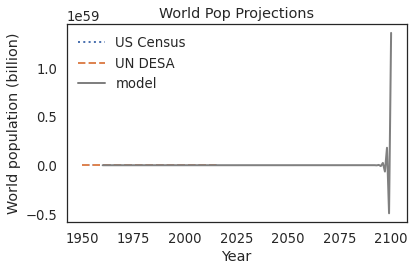

In [56]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label = 'US Census')
    plot(un, '--', label = 'UN DESA')
    plot(timeseries, color = 'gray', label = 'model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title = title)



plot_results(census, un, results, "World Pop Projections")

**Related viewing:** You might be interested in this [video by Hans Rosling about the demographic changes we expect in this century](https://www.youtube.com/watch?v=ezVk1ahRF78).